##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder

filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
df = pd.read_csv(filepath)
df.head()

In [ ]:
print(df.shape)
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

# Data Cleaning
## Drop Columns
- Drop all containing names and descriptions.
- Drop "Square Footage", "Import/Export Status" and "Fiscal Year End" as 
most/all row data are empty.
- Drop "Company Status" as all row data are "active".

In [ ]:
def processData(df):
    # Drop columns
    df = df.drop(columns=[
        "AccountID",
        "Company",
        "Industry",
        "8-Digit SIC Description", 
        "Parent Company",
        "Parent Country",
        "Company Description", 
        "Square Footage",
        "Company Status (Active/Inactive)",
        "Employees (Single Site)",
        "Import/Export Status",
        "Fiscal Year End",
        "Global Ultimate Company",
        "Global Ultimate Country",
        "Domestic Ultimate Company"
    ])

    # Drop rows with missing values
    df = df.dropna(subset=[
        "LATITUDE", 
        "LONGITUDE",
        "Year Found",
        "Employees (Domestic Ultimate Total)",
        "Employees (Global Ultimate Total)",
    ])

    # Convert "Year Found" to "Age"
    df["Age"] = dt.datetime.now().year - df["Year Found"]
    df = df.drop(columns=["Year Found"])

    # One Hot Encoding for "Entity Type" and "Ownership Type"
    df = pd.get_dummies(df, columns=["Entity Type"], prefix='Entity_Type')
    df = pd.get_dummies(df, columns=["Ownership Type"], prefix='Ownership_Type')

    # Label Encoding for "SIC Code"
    label_encoder = LabelEncoder()
    df["SIC Code"] = label_encoder.fit_transform(df["SIC Code"])
    
    # Label Encoding for "8-Digit SIC Code"
    label_encoder = LabelEncoder()
    df["8-Digit SIC Code"] = label_encoder.fit_transform(df["8-Digit SIC Code"])

    # Convert "Is Domestic Ultimate" and "Is Global Ultimate" to True/False
    df["Is Domestic Ultimate"] = df["Is Domestic Ultimate"] == 1
    df["Is Global Ultimate"] = df["Is Global Ultimate"] == 1

    return df

df = processData(df)
print(df.info())
df.head()

# Exploratory Data Analysis

# Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Separate features and target variable
X = df.drop("Sales (Domestic Ultimate Total USD)", axis=1)
y = df["Sales (Domestic Ultimate Total USD)"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

In [ ]:
# Lists to store results
n_folds_values = list(range(4, 16))
mean_r2_scores = []
std_r2_scores = []

# Iterate over different numbers of folds
for n_folds in n_folds_values:
    # Use k-fold cross-validation with the current number of folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Perform cross-validation and get R-squared scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    # Append mean and standard deviation of R-squared scores to lists
    mean_r2_scores.append(cv_scores.mean())
    std_r2_scores.append(cv_scores.std())

# Plot the results
plt.errorbar(n_folds_values, mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', label='R-squared scores')
plt.xlabel('Number of Folds')
plt.ylabel('R-squared Score')
plt.title('Cross-Validated R-squared Scores for Different Numbers of Folds')
plt.legend()
plt.show()

In [ ]:
# Use k-fold cross-validation with 10 folds
model_10 = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get R-squared scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Print the R-squared scores for each fold
print("Cross-Validation R-squared scores:", cv_scores)

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Train the model on the entire training set
model_10.fit(X_train, y_train)

# Evaluate the model on the test set
test_score = model_10.score(X_test, y_test)
print("Test R-squared score:", test_score)

In [ ]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(model_10, 'base_model.h5')

In [ ]:
def test_model(data):
    # we assume the data is cleaned
    # To load the model in the future
    loaded_model = joblib.load('./base_model.h5')
    predictions = loaded_model.predict(data)

    return predictions

# Extract the last row of the test set
last_row = X_test.iloc[[1]]

# Make predictions on the last row
print(test_model(last_row))


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    processData(hidden_data)
    result = test_model(hidden_data)
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### EDA
We will now proceed to analyze and visualize a subset of our data to gain some rough insight into how inputs in our data are related to our outputs.

In [ ]:
# use of a correlation matrix to observe how variables in our dataset may be affected by others
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
correlation_matrix = numerical_df.corr()

# Assuming correlation_matrix is your correlation matrix
correlation_df = pd.DataFrame(correlation_matrix)

# Print or use the correlation DataFrame as needed
correlation_df

###Geospatial Analysis

In [ ]:
# import required libraries
import matplotlib.pyplot as plt

# we will need this for the color gradient representing how high the domestic sales figure is.
from matplotlib.colors import LogNorm
import seaborn as sns

In [ ]:
# for the upcoming geospatial analysis portion, we will use a small subset of the data provided for plotting.
filtered_df = df[df['SIC Code'].isin([5099, 1611, 8711, 4789])]

filtered_df.head(2)

ValueError: zero-size array to reduction operation minimum which has no identity

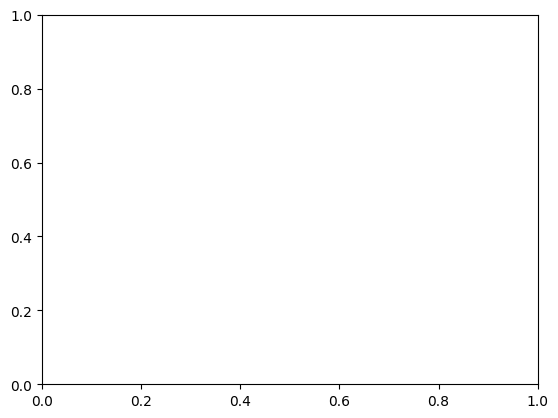

In [292]:
# read in the filtered dataset and do EDA. confusion matrix, etc
# Use LogNorm for more sensitivity to numerical changes
norm = LogNorm()

# Define a constant color (e.g., blue)
constant_color = 'blue'

# Define a color palette based on unique industries
industry_palette = sns.color_palette('Set1', n_colors=len(filtered_df['Sales (Domestic Ultimate Total USD)'].unique()))

# Create a dictionary to map Industry to a unique color
industry_colors = dict(zip(filtered_df['Sales (Domestic Ultimate Total USD)'].unique(), industry_palette))

# Scatter plot with varying color by Industry and varying alpha based on Sales values
scatter = plt.scatter(filtered_df['LONGITUDE'], filtered_df['LATITUDE'], c=filtered_df['Sales (Domestic Ultimate Total USD)'].map(industry_colors), s=3, alpha=norm(filtered_df['Sales (Domestic Ultimate Total USD)']))

# Add a legend for Industry
legend_labels = filtered_df['Sales (Domestic Ultimate Total USD)'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=industry,
                              markerfacecolor=industry_colors[industry], markersize=4) for industry in legend_labels]
plt.legend(handles=legend_handles, title='Sales (Domestic Ultimate Total USD)', prop={'size': 5}, loc='upper left', bbox_to_anchor=(1, 1))

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Varying Color by Industry and Varying Alpha Based on Sales (LogNorm)')

# Show the plot
plt.show()